In [47]:
!pip install pyro-ppl --upgrade

Requirement already up-to-date: pyro-ppl in /anaconda3/lib/python3.7/site-packages (1.0.0)


In [1]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.infer.predictive import Predictive as pred
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
from imblearn.under_sampling import RandomUnderSampler
import pickle
from mpl_toolkits.mplot3d import Axes3D


pyro.set_rng_seed(1)
# assert pyro.__version__.startswith('0.4.1')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils import *
from model import *

In [3]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

## Data

In [4]:
data = data_csv('only_space')

In [5]:
data

,Unnamed: 0,Unnamed: 0.1,CensusTract,TotalPop,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,...,FamilyWork,Unemployment,restaurants,bar,park,subway_station,FELONY,MISDEMEANOR,VIOLATION,target
0,0,0,36005000200,5403.0,72034.0,13991.0,22180.0,2206.0,20.0,20.7,...,0.0,7.7,207.0,6.0,16.0,0.0,12,19,7,38
1,1,1,36005000400,5915.0,74836.0,8407.0,27700.0,2449.0,13.2,23.6,...,0.6,9.5,395.0,7.0,47.0,0.0,16,38,4,58
2,2,2,36005001600,5879.0,32312.0,6859.0,17526.0,2945.0,26.3,35.9,...,0.0,8.7,140.0,4.0,23.0,0.0,16,36,7,59
3,3,3,36005001900,2591.0,37936.0,3771.0,17986.0,2692.0,37.1,31.5,...,0.0,19.2,626.0,68.0,66.0,15.0,28,72,11,111
4,4,4,36005002000,8516.0,18086.0,3694.0,12023.0,2346.0,53.2,67.7,...,0.0,17.2,120.0,5.0,15.0,0.0,28,66,18,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,2088,2088,36085030301,4895.0,65606.0,11825.0,29014.0,3763.0,8.7,11.1,...,0.3,7.4,200.0,4.0,7.0,0.0,21,58,13,92
2089,2089,2089,36085030302,6279.0,76542.0,8095.0,25189.0,3131.0,19.0,27.8,...,0.0,6.2,300.0,12.0,11.0,0.0,21,37,10,68
2090,2090,2090,36085031901,2550.0,25064.0,7879.0,12753.0,2439.0,39.3,51.4,...,0.0,13.8,120.0,3.0,7.0,0.0,23,50,14,87
2091,2091,2091,36085031902,4611.0,22656.0,8776.0,16303.0,2818.0,41.2,53.8,...,0.0,9.4,266.0,0.0,9.0,0.0,19,41,13,73


## Helper Functions

In [6]:
#Global variables
bool_split = 39
offset = 0
features = ['TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment','restaurants', 'bar', 'park', 'subway_station']
target = 'binary_target'    

In [7]:
imp_features =  ['TotalPop', 'IncomePerCap', 'restaurants','ChildPoverty','PrivateWork','park']

## Get Test and Train dataset 

In [8]:
X_nuts_train, y_nuts_train,month_train, X_nuts_test, y_nuts_test,month_test = get_data(data, imp_features, bool_split, offset)

In [ ]:
tnse_dict = get_tnse_dict(X_nuts_train, X_nuts_test)

## Vizualizer helpers

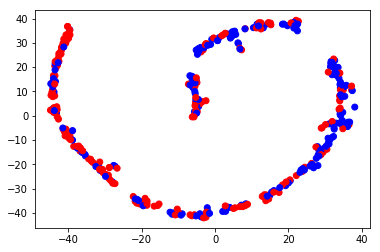

In [11]:
f = low_dim_2d(tnse_dict, y_nuts_test.numpy())

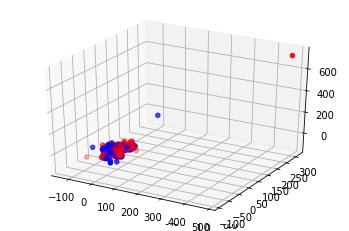

In [12]:
f = low_dim_3d(tnse_dict, y_nuts_test.numpy())

## Logistic Regression Baseline

In [9]:
reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
print('-'*30)

Train Score :  0.6846100759144237
Test Score : 0.6446280991735537
------------------------------


In [10]:
k = low_dim_2d(tnse_dict, reg.predict(X_nuts_test))

NameError: name 'tnse_dict' is not defined

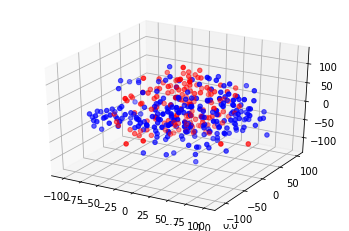

In [15]:
k = low_dim_3d(reg.predict(X_nuts_test))

## Bayesian  Baseline

In [10]:
# from model import model_basline, guide_baseline
svi, elbo_arr = infer(X_nuts_train, y_nuts_train, model_baseline, guide_baseline)

Elbo loss: 958.9429931640625
Elbo loss: 904.6605224609375
Elbo loss: 891.9682006835938
Elbo loss: 884.7180786132812
Elbo loss: 884.3927001953125
Elbo loss: 883.7925415039062
Elbo loss: 880.7952270507812
Elbo loss: 904.5743408203125
Elbo loss: 880.9418334960938
Elbo loss: 881.5691528320312
Elbo loss: 883.5243530273438
Elbo loss: 883.7274780273438
Elbo loss: 882.5331420898438
Elbo loss: 888.467529296875
Elbo loss: 883.9232177734375
Elbo loss: 880.28173828125
Elbo loss: 883.7158203125
Elbo loss: 881.1231079101562
Elbo loss: 883.60791015625
Elbo loss: 882.0861206054688


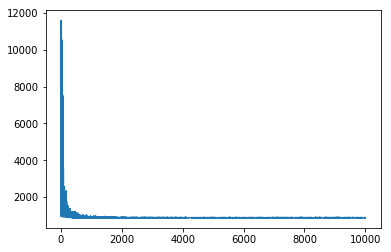

In [11]:
plt.plot(elbo_arr)

In [13]:
model_preds, y_pred, acc = predict(X_nuts_test, y_nuts_test, model_baseline, guide_baseline)

In [14]:
acc

0.6473829201101928

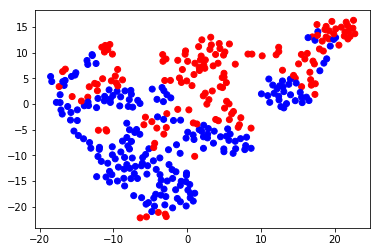

In [21]:
k = low_dim_2d(y_pred)

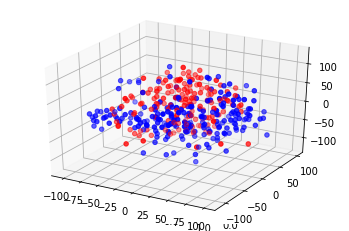

In [22]:
k = low_dim_3d(y_pred)

# Model 2 : Adding noise to add randomness to spatial data 

In [15]:
svi, elbo_arr = infer(X_nuts_train, y_nuts_train, model_2, guide_2)


Elbo loss: 1145.5162353515625
Elbo loss: 906.9969482421875
Elbo loss: 910.943115234375
Elbo loss: 908.05712890625
Elbo loss: 909.797607421875
Elbo loss: 907.3856201171875
Elbo loss: 908.8485107421875
Elbo loss: 908.22705078125
Elbo loss: 906.6702270507812
Elbo loss: 906.4091186523438
Elbo loss: 908.6656494140625
Elbo loss: 910.2813110351562
Elbo loss: 909.844482421875
Elbo loss: 908.804931640625
Elbo loss: 902.3824462890625
Elbo loss: 907.512939453125
Elbo loss: 909.3334350585938
Elbo loss: 906.3392333984375
Elbo loss: 907.236083984375
Elbo loss: 907.532470703125


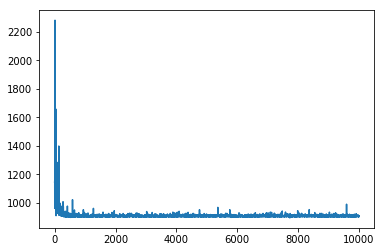

In [16]:
plt.plot(elbo_arr)

In [17]:
model_preds, y_pred, acc = predict(X_nuts_test, y_nuts_test, model_2, guide_2)

In [18]:
acc

0.6584022038567493

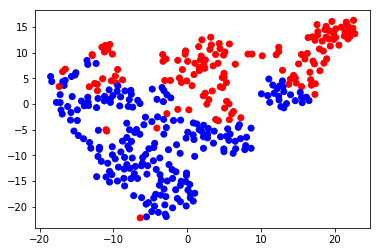

In [28]:
k = low_dim_2d(y_pred_2)

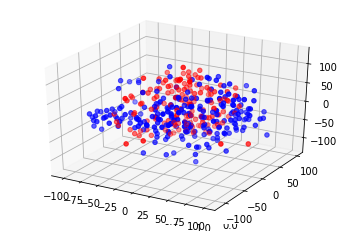

In [29]:
k = low_dim_3d(y_pred_2)

## ICAR Model

In [38]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
node1, node2 = get_nodes(hops=1)

In [40]:
svi, elbo_arr = infer(X_nuts_train, y_nuts_train, model_icar, guide_icar, node1, node2)

Elbo loss: 1005.2152709960938
Elbo loss: 1005.5077514648438
Elbo loss: 1006.9535522460938
Elbo loss: 1006.6511840820312
Elbo loss: 1007.4315795898438
Elbo loss: 1005.1209716796875
Elbo loss: 1007.5366821289062
Elbo loss: 1006.0550537109375
Elbo loss: 1007.1829833984375
Elbo loss: 1005.4675903320312
Elbo loss: 1008.1171264648438
Elbo loss: 1007.017333984375
Elbo loss: 1005.8182373046875
Elbo loss: 1006.287841796875
Elbo loss: 1006.9064331054688
Elbo loss: 1006.9268188476562
Elbo loss: 1005.8262939453125
Elbo loss: 1005.822021484375
Elbo loss: 1007.2268676757812
Elbo loss: 1005.847412109375


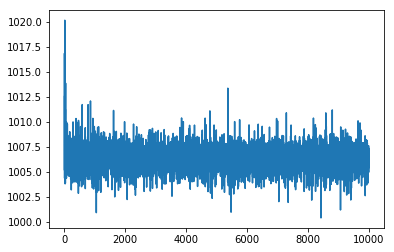

In [42]:
plt.plot(elbo_arr)

In [44]:
model_preds_3, y_pred_3, acc_3 = predict(X_nuts_test, y_nuts_test, model_icar, guide_icar, node1, node2)

In [45]:
acc_3

0.512396694214876

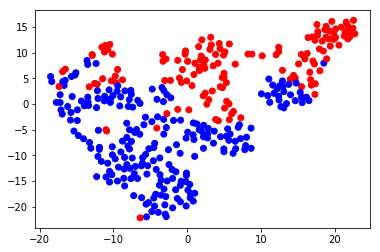

In [66]:
k = low_dim_2d(y_pred_3)

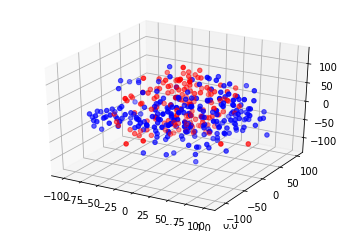

In [67]:
k = low_dim_3d(y_pred_3)

## ICAR Model with 2 hops

In [46]:
node1, node2 = get_nodes(hops=2)

In [47]:
svi, elbo_arr = infer(X_nuts_train, y_nuts_train, model_icar, guide_icar, node1, node2)

Elbo loss: 1013.8261108398438
Elbo loss: 1006.7259521484375
Elbo loss: 1006.9990844726562
Elbo loss: 1006.4995727539062
Elbo loss: 1005.4210815429688
Elbo loss: 1006.7694702148438
Elbo loss: 1006.6303100585938
Elbo loss: 1006.7759399414062
Elbo loss: 1006.3362426757812
Elbo loss: 1006.0947265625
Elbo loss: 1007.021240234375
Elbo loss: 1005.8126831054688
Elbo loss: 1007.843017578125
Elbo loss: 1006.2017211914062
Elbo loss: 1006.6546020507812
Elbo loss: 1007.1215209960938
Elbo loss: 1004.44970703125
Elbo loss: 1007.0541381835938
Elbo loss: 1006.8892822265625
Elbo loss: 1006.6295166015625


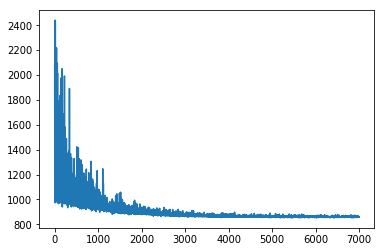

In [19]:
plt.plot(elbo_arr_icar_2)


In [21]:
model_preds_5, y_pred_5, acc_5 = predict(X_nuts_test, model_icar, guide_icar, node1_h2, node2_h2)


In [22]:
acc_5

0.7024793388429752

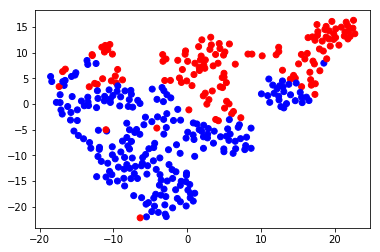

In [23]:
k = low_dim_2d(y_pred_5)

NameError: name 'elbo_arr_icar' is not defined